In [1]:
# Import libraries

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.calibration import CalibratedClassifierCV

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import os
import re
import time
from collections import Counter
from collections import defaultdict

# Word Cloud 
from wordcloud import WordCloud

# plotly
import plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode; init_notebook_mode(connected=True)
from plotly import tools

# nltk
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
stop_words.remove('no')
stop_words.remove('not')
stop_words.add('company')
stop_words.add('work')
stop_words.add('people')
stop_words.add('ever')
from nltk.tokenize import RegexpTokenizer; tokenizer = RegexpTokenizer(r'\w+')
from nltk.stem import WordNetLemmatizer
from nltk import ngrams, word_tokenize

In [2]:
# initialize dataframe
start = time.time()
df = pd.read_csv('data/employee_reviews.csv', index_col=0)
df = df[['pros', 'cons']]

In [3]:
df.head()

,pros,cons
1,People are smart and friendly,Bureaucracy is slowing things down
2,"1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...
3,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g..."
4,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...
5,Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv..."


In [4]:
# contraction removal
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [5]:
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [6]:
# tokenization with stop words removed
pros_batch = list()
cons_batch = list()
for pros, cons in zip(df['pros'], df['cons']):
    pros = replace_contractions(pros)
    words = tokenizer.tokenize(str(pros))
    pros_batch.append(words)
    cons = replace_contractions(cons)
    words = tokenizer.tokenize(str(cons))
    cons_batch.append(words)  

In [7]:
# lemmatization
pros_lem = list()
cons_lem = list()
for p, c in zip(pros_batch, cons_batch):
    pros_no_stop = [word.lower() for word in p if word.lower() not in stop_words]
    lemm = WordNetLemmatizer()
    pros_lem_temp = [lemm.lemmatize(word) for word in pros_no_stop]
    pros_lem.append(" ".join(pros_lem_temp))
    cons_no_stop = [word.lower() for word in c if word.lower() not in stop_words]
    lemm = WordNetLemmatizer()
    cons_lem_temp = [lemm.lemmatize(word) for word in cons_no_stop]
    cons_lem.append(" ".join(cons_lem_temp))

In [8]:
# combine all reviews into one long list
batch = pros_lem + cons_lem
# pros are labeled as '1' and cons are labeled as '0'
labels = [1] * len(pros_batch) + [0] * len(cons_batch)

In [9]:
# specify path for saving models
path = 'models'
if not os.path.exists(path):
    os.mkdir(path)

In [10]:
# building the classifier
count_vec = CountVectorizer(ngram_range=(1,2))
X_counts = count_vec.fit_transform(batch)

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

pickle.dump(count_vec, open(path + "/" + "count_vec.pk1", "wb"))

# have 70% of the data as training data, 30% as testing data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, labels, test_size=0.3)

Naive Bayes Accuracy on the companies dataset: 93.48%
Model NB saved to path

Naive Bayes Confustion Matrix


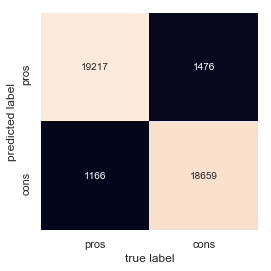

In [11]:
# Naive Bayes Classifier: ~93.5% accuracy
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
    
acc = accuracy_score(y_test, y_pred)
print("Naive Bayes Accuracy on the companies dataset: {:.2f}%".format(acc*100))
pickle.dump(nb, open(path + "/" + "model_nb.pk1", "wb"))
print("Model NB saved to path")

# Visualizing the results using Confusion Matrix
print("\nNaive Bayes Confustion Matrix")
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['pros','cons'], yticklabels=['pros','cons'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

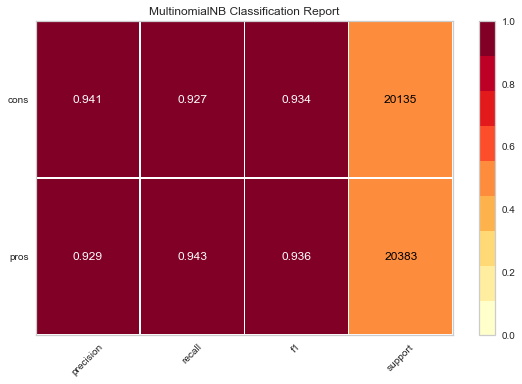

In [12]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(nb, classes=['pros', 'cons'], support=True)
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data


Linear SVC Accuracy on the companies dataset: 94.32%
Model LinearSVC saved to path

Linear Support Vector Classifier Confustion Matrix


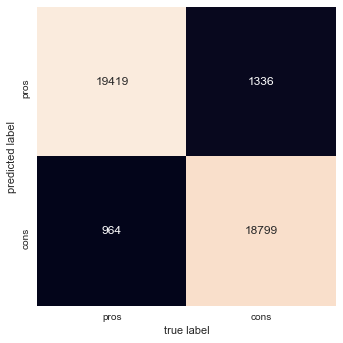

In [13]:
# Linear Support Vector Classifier: ~94.5% accuracy
l_svc = CalibratedClassifierCV(base_estimator=LinearSVC(penalty='l2', dual=False), cv=5)
l_svc.fit(X_train, y_train)
y_pred = l_svc.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("\nLinear SVC Accuracy on the companies dataset: {:.2f}%".format(acc*100))
pickle.dump(l_svc, open(path + "/" + "model_lsvc.pk1", "wb"))
print("Model LinearSVC saved to path")

# Visualizing the results using Confusion Matrix
print("\nLinear Support Vector Classifier Confustion Matrix")
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['pros','cons'], yticklabels=['pros','cons'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

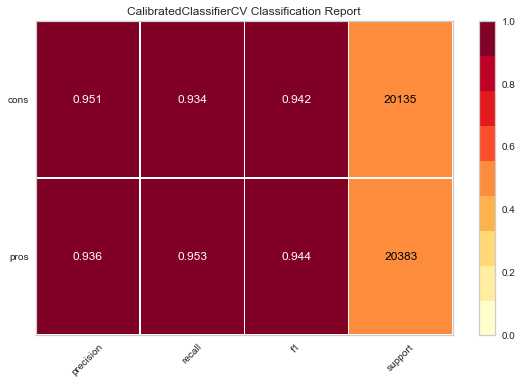

In [14]:
visualizer = ClassificationReport(l_svc, classes=['pros', 'cons'], support=True)
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data


Logistic Regression Accuracy on the companies dataset: 93.61%
Model Log Reg  saved to path

Logistic Regression Confustion Matrix


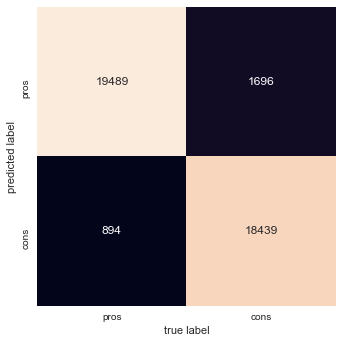

In [15]:
# Logistic Regression: ~93% accuracy
lr = LogisticRegression(solver='newton-cg')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("\nLogistic Regression Accuracy on the companies dataset: {:.2f}%".format(acc*100))
pickle.dump(lr, open(path + "/" + "model_lr.pk1", "wb"))
print("Model Log Reg  saved to path")

# Visualizing the results using Confusion Matrix
print("\nLogistic Regression Confustion Matrix")
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['pros','cons'], yticklabels=['pros','cons'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

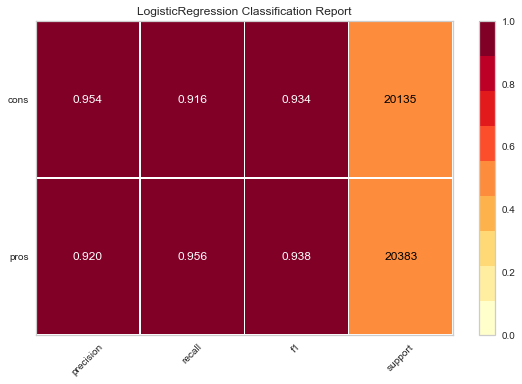

In [16]:
visualizer = ClassificationReport(lr, classes=['pros', 'cons'], support=True)
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data


Word Cloud of Positive Review


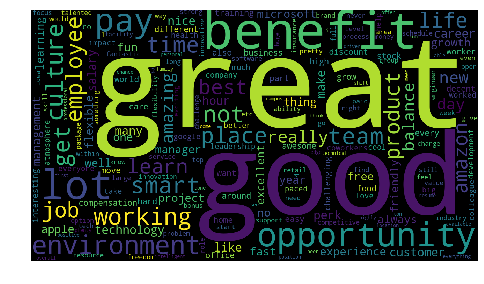

In [17]:
# Pros Word Cloud
pros_cloud = list()
for sent in pros_lem:
    tmp = sent.split()
    pros_cloud += tmp

print("\nWord Cloud of Positive Review")
word_cnt = Counter(pros_cloud)
reviews_cloud = WordCloud(background_color='black', width=1280, height=720).generate_from_frequencies(word_cnt)
plt.imshow(reviews_cloud)
plt.axis('off')
plt.show()


Word Cloud of Negative Review


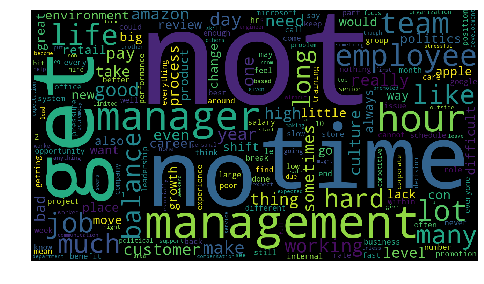

In [18]:
# Cons Word Cloud
cons_cloud = list()
for sent in cons_lem:
    tmp = sent.split()
    cons_cloud += tmp

print("\nWord Cloud of Negative Review")
word_cnt = Counter(cons_cloud)
reviews_cloud = WordCloud(background_color='black', width=1280, height=720).generate_from_frequencies(word_cnt)
plt.imshow(reviews_cloud)
plt.axis('off')
plt.show()

In [19]:
# n grams
plot_path = 'plot'

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordFreq"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        )
    )
    return trace

# tokenize words in pros/cons_lemm for n grams
pros_token = list()
cons_token = list()
for p, c in zip(pros_lem, cons_lem):
    pros_token.append(word_tokenize(p))
    cons_token.append(word_tokenize(c))
    
reviews_batch = pros_token + cons_token

In [20]:
# Plotting the unigram plot (Pros)
reviews_df = pd.DataFrame({'Reviews':pros_token})
unigram_dict = defaultdict(int)

for sentence in reviews_df["Reviews"]:
    if len(sentence) > 1:
        bigram = ngrams(sentence, 1)
        for gram in bigram:
            unigram_dict[" ".join([g for g in gram])] += 1


fd_sorted = pd.DataFrame(sorted(unigram_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordFreq"]
sym_2 = horizontal_bar_chart(fd_sorted.head(50), '#077A07')
                             
fig = tools.make_subplots(
        rows=1, 
        cols=2, 
        vertical_spacing=0.04,
        horizontal_spacing=0.05,
        subplot_titles=["","Frequent Unigram of Positive Reviews"])
fig.append_trace(sym_2, 1, 2)
fig['layout'].update(
        height=1080, 
        width=800, 
        paper_bgcolor='rgb(233,233,233)', 
        title="Unigram Plots of Positive Reviews Keywords after removing Stopwords")
plotly.offline.iplot(fig) # jupyter notebook only

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [21]:
# Plotting the bigram plot (Pros)
reviews_df = pd.DataFrame({'Reviews':pros_token})
bigram_dict = defaultdict(int)

for sentence in reviews_df["Reviews"]:
    if len(sentence) > 1:
        bigram = ngrams(sentence, 2)
        for gram in bigram:
            bigram_dict[" ".join([g for g in gram])] += 1


fd_sorted = pd.DataFrame(sorted(bigram_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordFreq"]
sym_2 = horizontal_bar_chart(fd_sorted.head(50), '#CC3333')
                             
fig = tools.make_subplots(
        rows=1, 
        cols=2, 
        vertical_spacing=0.04,
        horizontal_spacing=0.05,
        subplot_titles=["","Frequent Bigrams of Positive Reviews"])
fig.append_trace(sym_2, 1, 2)
fig['layout'].update(
        height=1080, 
        width=800, 
        paper_bgcolor='rgb(233,233,233)', 
        title="Bigram Plots of Positive Reviews Keywords after removing Stopwords")
plotly.offline.iplot(fig) # jupyter notebook only

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [22]:
# Plotting the trigram plot (Pros)
trigram_dict = defaultdict(int)

for sentence in reviews_df["Reviews"]:
    if len(sentence) > 1:
        trigram = ngrams(sentence, 3)
        for gram in trigram:
            trigram_dict[" ".join([g for g in gram])] += 1
        
fd_sorted = pd.DataFrame(sorted(trigram_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordFreq"]
sym_3 = horizontal_bar_chart(fd_sorted.head(50), '#333399')
                             
fig = tools.make_subplots(
        rows=1, 
        cols=2, 
        vertical_spacing=0.04,
        horizontal_spacing=0.05,
        subplot_titles=["", "Frequent Trigrams of Positive Reviews"])
fig.append_trace(sym_3, 1, 2)
fig['layout'].update(
        height=1080, 
        width=800, 
        paper_bgcolor='rgb(233,233,233)', 
        title="Trigram Plots of Positive Reviews Keywords after removing Stopwords")
plotly.offline.iplot(fig) # jupyter notebook only

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [23]:
# Plotting the unigram plot (Cons)
reviews_df = pd.DataFrame({'Reviews':cons_token})
unigram_dict = defaultdict(int)

for sentence in reviews_df["Reviews"]:
    if len(sentence) > 1:
        bigram = ngrams(sentence, 1)
        for gram in bigram:
            unigram_dict[" ".join([g for g in gram])] += 1


fd_sorted = pd.DataFrame(sorted(unigram_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordFreq"]
sym_2 = horizontal_bar_chart(fd_sorted.head(50), '#077A07')
                             
fig = tools.make_subplots(
        rows=1, 
        cols=2, 
        vertical_spacing=0.04,
        horizontal_spacing=0.05,
        subplot_titles=["","Frequent Unigrams of Negative Reviews"])
fig.append_trace(sym_2, 1, 2)
fig['layout'].update(
        height=1080, 
        width=800, 
        paper_bgcolor='rgb(233,233,233)', 
        title="Unigram Plots of Negative Reviews Keywords after removing Stopwords")
plotly.offline.iplot(fig) # jupyter notebook only

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [24]:
# Plotting the bigram plot (Cons)
reviews_df = pd.DataFrame({'Reviews':cons_token})
bigram_dict = defaultdict(int)

for sentence in reviews_df["Reviews"]:
    if len(sentence) > 1:
        bigram = ngrams(sentence, 2)
        for gram in bigram:
            bigram_dict[" ".join([g for g in gram])] += 1


fd_sorted = pd.DataFrame(sorted(bigram_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordFreq"]
sym_2 = horizontal_bar_chart(fd_sorted.head(50), '#CC3333')
                             
fig = tools.make_subplots(
        rows=1, 
        cols=2, 
        vertical_spacing=0.04,
        horizontal_spacing=0.05,
        subplot_titles=["","Frequent Bigrams of Negative Reviews"])
fig.append_trace(sym_2, 1, 2)
fig['layout'].update(
        height=1080, 
        width=800, 
        paper_bgcolor='rgb(233,233,233)', 
        title="Bigram Plots of Negative Reviews Keywords after removing Stopwords")
plotly.offline.iplot(fig) # jupyter notebook only

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [25]:
# Plotting the trigram plot (Cons)
trigram_dict = defaultdict(int)

for sentence in reviews_df["Reviews"]:
    if len(sentence) > 1:
        trigram = ngrams(sentence, 3)
        for gram in trigram:
            trigram_dict[" ".join([g for g in gram])] += 1
        
fd_sorted = pd.DataFrame(sorted(trigram_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordFreq"]
sym_3 = horizontal_bar_chart(fd_sorted.head(50), '#333399')
                             
fig = tools.make_subplots(
        rows=1, 
        cols=2, 
        vertical_spacing=0.04,
        horizontal_spacing=0.05,
        subplot_titles=["", "Frequent Trigrams of Negative Reviews"])
fig.append_trace(sym_3, 1, 2)
fig['layout'].update(
        height=1080, 
        width=800, 
        paper_bgcolor='rgb(233,233,233)', 
        title="Trigram Plots of Negative Reviews Keywords after removing Stopwords")
plotly.offline.iplot(fig) # jupyter notebook only

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]

